# Convolution speed tests


Comparing the convolution speeds to PyAstronomy. Our rotational convolution is faster than PyAstronomy's slow convolution. It is significantly slower than PyAstronomy's fast convoluions that use a fixed kernel (valid only for a small wavelength range). We use a wavelength variable kernel which is unique for each pixel, (hence takes longer). Returning cached convolution results is faster then PyAstronomy's convolutions.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PyAstronomy.pyasl as pyasl

import eniric
#eniric.cache["location"] = None  # Disable caching for these tests
eniric.cache["location"] = ".joblib"  # Enable caching

from eniric.broaden import rotational_convolution, resolution_convolution
from eniric.utilities import band_limits, load_aces_spectrum, wav_selector
from eniric_scripts.aces_precision import convolve_and_resample 


## Load data
Select test spectra, flux1 is a M0 spectra, flux2 is a M9 spectra.

In [2]:
wav1, flux1 = load_aces_spectrum([3900, 4.5, 0.0, 0])
# wav2, flux2 = load_aces_spectrum([2600, 4.5, 0.0, 0])

In [3]:
wav1, flux1 = wav_selector(wav1, flux1, *band_limits("K"))
# wav2, flux2 = wav_selector(wav2, flux2, *band_limits("K"))

In [4]:
# PyAstronomy requires even spaced waelength (eniric does not)
wav = np.linspace(wav1[0], wav1[-1], len(wav1))

flux1 = np.interp(wav, wav1, flux1)
#flux2 = np.interp(wav, wav2, flux2)

In [5]:
# Convolution settings
epsilon = 0.6
vsini = 10.0
R = 40000

### Rotational convolution

In [6]:
%%time 
rot_fast = pyasl.fastRotBroad(wav, flux1, epsilon, vsini)
## Wall time: 15.2 ms

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.7 ms


In [7]:
%%time 
rot_slow = pyasl.rotBroad(wav, flux1, epsilon, vsini)
## Wall time: 36 s

CPU times: user 35.9 s, sys: 2.67 ms, total: 35.9 s
Wall time: 36.2 s


In [8]:
%%time
# Rotational_convolution does not need evenly spaced spectra.
# Using it here for comparible testing.
# Before caching
eniric_rot = rotational_convolution(wav, wav, flux1, vsini, epsilon=epsilon)
## Wall time: 3.3 s

100%|██████████| 70000/70000 [00:02<00:00, 25136.19it/s]


CPU times: user 1.38 s, sys: 42.8 ms, total: 1.43 s
Wall time: 3.6 s


In [9]:
%%time
# After caching
eniric_rot = rotational_convolution(wav, wav, flux1, vsini, epsilon=epsilon)
## Wall time: 4.2 ms

CPU times: user 4.33 ms, sys: 3 µs, total: 4.33 ms
Wall time: 5.49 ms


The rotational convolution in eniric is ~10x faster than
the precise version in Pyastronomy and does not require equal wavelength steps.
It is ~1000x slower then the fast rotational convolution that uses a fixed kernel and only valid for short regions.

### Resolution convolution


In [10]:
%%time 
res_fast = pyasl.instrBroadGaussFast(wav, flux1,R, maxsig=5)
## Wall time: 19.2 ms

CPU times: user 21.1 ms, sys: 2 µs, total: 21.1 ms
Wall time: 21 ms


In [11]:
%%time 
# Before caching
eniric_res = resolution_convolution(
    wav_band=wav, wav_extended=wav, flux_conv_rot=flux1,
    R=R, fwhm_lim=5, num_procs=4, normalize=True)
## Wall time: 3.07 s

100%|██████████| 70000/70000 [00:02<00:00, 25632.64it/s]


CPU times: user 1.44 s, sys: 41.8 ms, total: 1.48 s
Wall time: 3.35 s


In [12]:
%%time 
# Same calculation with cached result.
eniric_res = resolution_convolution(wav, wav, flux1, R=R)
## Wall time: 8.9 ms

CPU times: user 4.26 ms, sys: 0 ns, total: 4.26 ms
Wall time: 3.91 ms


Resolution convolution is around 500x slower 
although it can handle uneven wavelenght spacing and has variable kernal. 

## Compare the results of convolution
Eniric gives a comparible rotational convolution to PyAstronomy's slow version. The PyAstronomy Fast convolution gives different results, which are maximum at the edges.
PyAstronomy also has edge effects which are ignored using [10:-10] slicing.

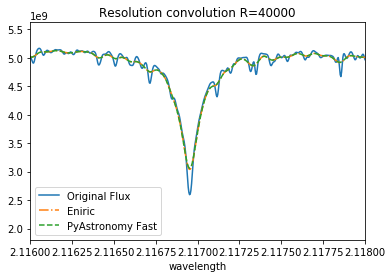

In [13]:
plt.plot(wav, flux1, label="Original Flux")
plt.plot(wav[100:-100], eniric_res[100:-100], "-.", label="Eniric")
plt.plot(wav[100:-100], res_fast[100:-100], "--", label="PyAstronomy Fast")
plt.xlim([2.116,2.118])
plt.xlabel("wavelength")
plt.title("Resolution convolution R={}".format(R))
plt.legend()
plt.show()


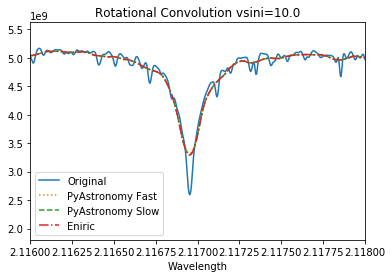

In [14]:
plt.plot(wav, flux1, label="Original")
plt.plot(wav, rot_fast,":", label="PyAstronomy Fast")
plt.plot(wav, rot_slow, "--", label="PyAstronomy Slow")
plt.plot(wav, eniric_rot,"-.", label="Eniric")
plt.xlabel("Wavelength")
plt.title("Rotational Convolution vsini={}".format(vsini))
plt.xlim((2.116, 2.118))
plt.legend()
plt.show()


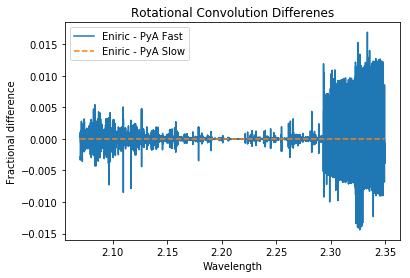

In [15]:
plt.plot(wav[100:-100], (eniric_rot[100:-100] - rot_fast[100:-100])/eniric_rot[100:-100], label="Eniric - PyA Fast")
plt.plot(wav[100:-100], (eniric_rot[100:-100] - rot_slow[100:-100])/eniric_rot[100:-100], "--", label="Eniric - PyA Slow")
plt.xlabel("Wavelength")
plt.ylabel("Fractional difference")
plt.title("Rotational Convolution Differenes")
#plt.xlim((2.3, 2.31))
plt.legend()
plt.show()


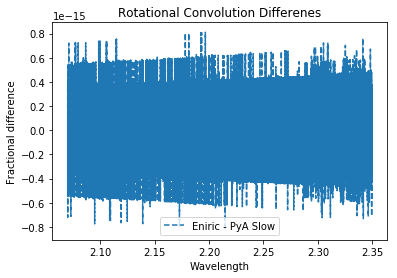

In [16]:
plt.plot(wav[50:-50], (eniric_rot[50:-50] - rot_slow[50:-50])/eniric_rot[50:-50], "--", label="Eniric - PyA Slow")
plt.xlabel("Wavelength")
plt.ylabel("Fractional difference")
plt.title("Rotational Convolution Differenes")
plt.legend()
plt.show()

assert np.allclose(eniric_rot[50:-50], rot_slow[50:-50])

PyAstronomy slow and eniric are identical (within 1e-13%) (except for edge effects). 

PyAstronomy Fast and eniric are different by up to 1.5%

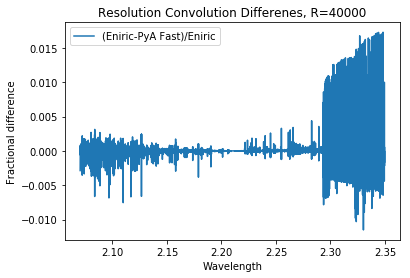

In [17]:
plt.plot(wav[100:-100], (eniric_res[100:-100] - res_fast[100:-100])/eniric_res[100:-100], label="(Eniric-PyA Fast)/Eniric")
plt.xlabel("Wavelength")
plt.ylabel("Fractional difference")
plt.title("Resolution Convolution Differenes, R={}".format(R))
# plt.xlim((2.3, 2.31))
plt.legend()
plt.show()


Resolution convolution is within 1.5% as well.